In [2]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import torch.nn as nn
import gym
import time

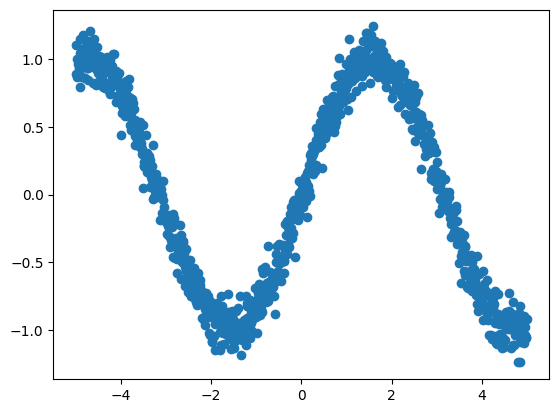

In [3]:
n = 1000
x_data = torch.linspace(-5, 5, n)
nu, scale = torch.tensor(0.), torch.tensor(0.1)
noise = torch.FloatTensor([torch.normal(nu, scale) for _ in range(n)])
y_data = torch.sin(x_data) + noise
plt.scatter(x_data, y_data)


step: 0, loss: 0.7198160886764526
step: 1, loss: 0.5739239454269409
step: 2, loss: 0.48608162999153137
step: 3, loss: 0.4317544102668762
step: 4, loss: 0.3976387083530426
step: 5, loss: 0.3781551718711853
step: 6, loss: 0.37517666816711426
step: 7, loss: 0.4029562771320343
step: 8, loss: 0.5042381286621094
step: 9, loss: 0.7942405343055725
step: 10, loss: 1.5768156051635742
step: 11, loss: 3.6412456035614014
step: 12, loss: 8.997814178466797
step: 13, loss: 22.41960334777832
step: 14, loss: 53.41022491455078
step: 15, loss: 109.78668975830078
step: 16, loss: 157.26304626464844
step: 17, loss: 99.49869537353516
step: 18, loss: 14.732048034667969
step: 19, loss: 1.4941229820251465
step: 20, loss: 0.913409411907196
step: 21, loss: 0.6172020435333252
step: 22, loss: 0.4477604925632477
step: 23, loss: 0.3503906726837158
step: 24, loss: 0.2935074269771576
step: 25, loss: 0.259250283241272
step: 26, loss: 0.2376316785812378
step: 27, loss: 0.22309479117393494
step: 28, loss: 0.212559491395950

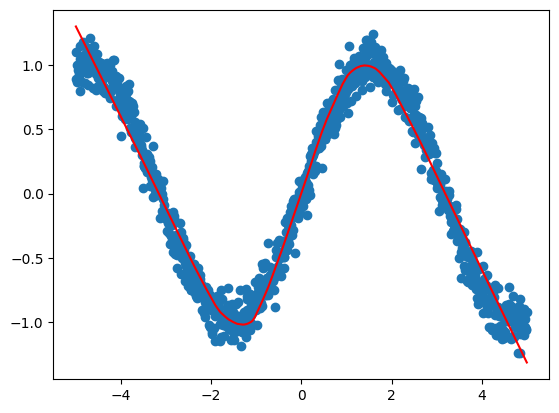

In [4]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 128)
        self.linear2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
        self.optimazer = torch.optim.SGD(self.parameters(), lr=1e-2)

    def forward(self, _input):
        hidden = self.linear1(_input)
        hidden = self.relu(hidden)
        output = self.linear2(hidden)
        return output
    
    def learn(self, x_data, y_data, step_n=1000):
        for step in range(step_n):
            y_pred = self.forward(x_data)
            loss = torch.mean((y_data - y_pred)**2)
            print(f'step: {step}, loss: {loss.data}')
            loss.backward()
            self.optimazer.step()
            self.optimazer.zero_grad()


network = Network()
network.learn(x_data.reshape(-1, 1), y_data.reshape(-1, 1))
y_pred = network(x_data.reshape(-1, 1))

plt.scatter(x_data, y_data)
plt.plot(x_data, y_pred.data, c = 'r')
plt.show()

In [5]:
x_data.reshape(-1, 1).shape

torch.Size([1000, 1])

In [12]:
env = gym.make('CartPole-v1')
state_dim = 4
action_n = 2

class CEM(nn.Module):
    def __init__(self, state_dim, action_n):
        super().__init__()
        self.state_dim = state_dim
        self.action_n = action_n
        self.network = nn.Sequential(nn.Linear(self.state_dim, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, action_n)
                                     )
        self.softmax = nn.Softmax()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, _input):
        return self.network(_input)

    def get_action(self, state):
        state = torch.FloatTensor(state)
        logits = self.forward(state)
        probs = self.softmax(logits).data.numpy()
        action = np.random.choice(self.action_n, p = probs)
        return action
    
    def fit(self, elite_trajectories):
        elite_states = []
        elite_actions = []
        for trajectory in elite_trajectories:
            for state, action in zip(trajectory['states'], trajectory['actions']):
                elite_states.append(state)
                elite_actions.append(action)
        elite_states = torch.FloatTensor(elite_states)
        elite_actions = torch.LongTensor(elite_actions)
        pred_actions = self.forward(elite_states)
        
        loss = self.loss(pred_actions, elite_actions)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()




    

def get_trajectory(env, agent, max_len=1000, viz=False):
    trajectory = {'states': [], 'actions': [], 'rewards': []}

    state = env.reset()

    for _ in range(max_len):
        trajectory["states"].append(state)

        action = agent.get_action(state)
        trajectory["actions"].append(action)

        state, reward, done, _ = env.step(action)
        trajectory['rewards'].append(reward)


        if viz:
            time.sleep(0.05)
            env.render()

        if done:
            break

    return trajectory

agent = CEM(state_dim, action_n)
q_param = 0.9
iteration_n = 50
trajectory_n = 20
trajectory_len = 500

for iteration in range(iteration_n):

    #policy evalution
    trajectories = [get_trajectory(env, agent) for _ in range(trajectory_n)]
    total_rewards = [np.sum(trajectory['rewards']) for trajectory in trajectories]
    print(f"iteration: {iteration}, mean total reward: {np.mean(total_rewards)}")

    #policy iteration
    quantile = np.quantile(total_rewards, q_param)
    elite_trajectories = []
    for trajectory in trajectories:
        total_reward = np.sum(trajectory['rewards'])
        if total_reward > quantile:
            elite_trajectories.append(trajectory)

    if len(elite_trajectories) > 0:
        agent.fit(elite_trajectories)

print(sum(trajectory['rewards']))

/home/eidel/anaconda3/envs/rl/lib/python3.10/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


iteration: 0, mean total reward: 31.0
iteration: 1, mean total reward: 34.85
iteration: 2, mean total reward: 39.4
iteration: 3, mean total reward: 41.5
iteration: 4, mean total reward: 43.25
iteration: 5, mean total reward: 40.1
iteration: 6, mean total reward: 45.35
iteration: 7, mean total reward: 59.0
iteration: 8, mean total reward: 61.9
iteration: 9, mean total reward: 69.2
iteration: 10, mean total reward: 82.05
iteration: 11, mean total reward: 74.85
iteration: 12, mean total reward: 86.25
iteration: 13, mean total reward: 106.95
iteration: 14, mean total reward: 124.25
iteration: 15, mean total reward: 103.75
iteration: 16, mean total reward: 134.2
iteration: 17, mean total reward: 134.7
iteration: 18, mean total reward: 120.85
iteration: 19, mean total reward: 133.15
iteration: 20, mean total reward: 176.9
iteration: 21, mean total reward: 169.85
iteration: 22, mean total reward: 197.7
iteration: 23, mean total reward: 241.5
iteration: 24, mean total reward: 250.05
iteration: